# Final Project: Phase 3: Manipulating Maps Data with Pandas

In [1090]:
%matplotlib inline
import numpy as np
import pandas as pd
import MySQLdb as mdb
import MySQL_data_file as MySQL_data
from datetime import datetime,time,timedelta
from dateutil.parser import parse
import matplotlib as plt

In [265]:
con = mdb.connect(MySQL_data.my_sql_host, MySQL_data.my_sql_user,\
                    MySQL_data.my_sql_passwd,\
                    MySQL_data.my_sql_database)
#con.close

In [266]:
def run_sql(query):
    cur = con.cursor()
    cur.execute(query)
    con.commit()
    #con.close()
    return cur.fetchall()

####Read in the data from MySQL and combine into a single DataFrame

In [267]:
gmaps_df = pd.read_sql("""SELECT entry_id,timestamp,datetime,origins,destinations,travel_mode,duration,distance,fare
                        FROM gmaps_data""",con)
bing_df = pd.read_sql("""SELECT entry_id,timestamp,datetime,origins,destinations,travel_mode,duration_traffic,distance * 1000,congestion
                        FROM mmaps_data""",con)
#changing the bing maps "duration_traffic" column to "duration" in order to match up the column with the gmaps_df
bing_df.columns = [u'entry_id', u'timestamp', u'datetime', u'origins', u'destinations', u'travel_mode', u'duration', u'distance', u'congestion']
#merging the two dataframes
combined_df = gmaps_df.merge(bing_df, how='outer')
#sorting the combined df by datetime
combined_df.sort(columns='datetime', inplace=True)
#reindexing the combined df to have chronological index
combined_df.index = np.arange(len(combined_df))
#print len(combined_df)
#combined_df.head()

####Save MySQL data as a CSV file and read in the CSV

In [268]:
combined_df.to_csv('ignore/sat_may16_afternoon_import.csv')

In [546]:
combined_df = pd.read_csv('ignore/sat_may16_afternoon_import.csv')

Rename columns of imported csv file. Drop redundant columns.

In [547]:
imported_combined_df = combined_df.copy()

In [548]:
imported_combined_df.columns = [u'pd_id', u'entry_id', u'timestamp', u'datetime', u'origins', u'destinations', u'travel_mode', u'duration', u'distance', u'fare', u'congestion']
imported_combined_df.drop(['entry_id','timestamp'], axis=1, inplace=True) #drop redundant entry_id's from MYSQL and replace with distinct pandas_id's

Remove all rows in the Combined DataFrame where duration is Null

In [549]:
#can also use sql to look for null values: select * from gmaps_data where duration is NULL
imported_combined_df = imported_combined_df.ix[pd.notnull(combined_df['duration']),:]
imported_combined_df.sort(columns='pd_id', ascending=True, inplace=True)

In [550]:
#compare total rows of current df with not null rows of previous df
#print len(combined_df[pd.isnull(combined_df['duration'])])
#print len(combined_df[pd.notnull(combined_df['duration'])])
print len(imported_combined_df)

69740


Remove all rows in the Combined DataFrame where duration is "0" (e.g. Oakland to Oakland)

In [551]:
#below code prints number of trips from Oakland to Oakland
#print len(imported_combined_df[((imported_combined_df['origins'] =='Oakland, CA, USA') & (imported_combined_df['destinations'] == 'Oakland, CA, USA'))])

In [552]:
imported_combined_df = imported_combined_df[combined_df['distance'] != 0]
#print len(imported_combined_df)
#code below prints out number of trips that are not from Oakland to Oakland
print len(imported_combined_df[((imported_combined_df['origins'] !='Oakland, CA, USA') | (imported_combined_df['destinations'] != 'Oakland, CA, USA'))])

69242


Convert (or rather) re-convert datetime column to numpy datetime format using pandas to_datetime function

In [553]:
imported_combined_df['datetime'] = pd.to_datetime(imported_combined_df['datetime']) #Note still in UTC time zone

In [554]:
imported_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69242 entries, 0 to 69923
Data columns (total 9 columns):
pd_id           69242 non-null int64
datetime        69242 non-null datetime64[ns]
origins         69242 non-null object
destinations    69242 non-null object
travel_mode     69242 non-null object
duration        69242 non-null float64
distance        69242 non-null float64
fare            23432 non-null float64
congestion      29688 non-null object
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 5.3+ MB


####Normalizing origin/destination names by replacing with shorter names

In [555]:
#The following code displays/stores the distinct names in the origins and destinations
origins_sorted = np.sort(pd.Series.unique(imported_combined_df['origins']))
destinations_sorted = np.sort(pd.Series.unique(imported_combined_df['destinations']))
#print len(origins_sorted); print len(destinations_sorted)

In [556]:
#this is the list of names that will be replacing longer names for origins/destinations
replacement_names = ['Oakland','Berkeley', 'Financial District', 'Mission',\
                     'Mountain View', 'Noe Valley', 'North Beach', 'Russian Hill',\
                     'Pacific Heights', 'Outer Sunset', 'Outer Richmond']

In [557]:
#the following code normalizes the district and city names in the origin and destination columns,
#replaces longer names with shorter names from list above
for short_name in replacement_names:
    imported_combined_df.ix[imported_combined_df['origins'].str.contains(short_name), 'origins'] = short_name
    imported_combined_df.ix[imported_combined_df['destinations'].str.contains(short_name), 'destinations'] = short_name

In [558]:
#check to make sure that name normalization was successful
##################################
#print np.sort(pd.Series.unique(imported_combined_df['origins']))
#print np.sort(pd.Series.unique(imported_combined_df['destinations']))
##################################
#making sure that there were no incidents in updating the origins and destinations
#by looking to see if any origin/destination pairs are equivalent
#len(imported_combined_df[imported_combined_df['origins'] != imported_combined_df['destinations']])

####Reindex the DataFrame using the 'datetime' column

In [559]:
imported_combined_df.index = imported_combined_df['datetime'].values

In [560]:
imported_combined_df.index = imported_combined_df.index.tz_localize('UTC')

In [561]:
imported_combined_df.index = imported_combined_df.index.tz_convert('US/Pacific')

In [562]:
imported_combined_df.index

<class 'pandas.tseries.index.DatetimeIndex'>
[2015-04-20 01:14:42-07:00, ..., 2015-05-16 11:00:06-07:00]
Length: 69242, Freq: None, Timezone: US/Pacific

In [563]:
imported_combined_df.sort_index(axis=0, ascending=True, inplace=True)

In [564]:
imported_combined_df.sort(columns=['datetime','origins','destinations','travel_mode'], inplace=True)
#this would display better after resampling (or at least removing seconds data)

In [565]:
imported_combined_df.tail(53)

,pd_id,datetime,origins,destinations,travel_mode,duration,distance,fare,congestion
2015-05-16 10:45:06-07:00,69870,2015-05-16 17:45:06,Berkeley,Mountain View,driving,3718,74000,NaN,None
2015-05-16 11:00:01-07:00,69872,2015-05-16 18:00:01,Russian Hill,Oakland,driving,1797,19000,NaN,Mild
2015-05-16 11:00:02-07:00,69904,2015-05-16 18:00:02,Berkeley,Financial District,transit,1831,19043,4,NaN
2015-05-16 11:00:02-07:00,69897,2015-05-16 18:00:02,Berkeley,Mountain View,transit,6060,81029,10,NaN
2015-05-16 11:00:02-07:00,69895,2015-05-16 18:00:02,Berkeley,Oakland,transit,1560,9092,NaN,NaN
2015-05-16 11:00:02-07:00,69881,2015-05-16 18:00:02,Mission,Financial District,transit,1377,5135,2,NaN
2015-05-16 11:00:02-07:00,69880,2015-05-16 18:00:02,Mission,Mountain View,transit,4979,59671,10,NaN
2015-05-16 11:00:02-07:00,69882,2015-05-16 18:00:02,Mission,Oakland,transit,2879,17529,NaN,NaN
2015-05-16 11:00:02-07:00,69878,2015-05-16 18:00:02,Noe Valley,Financial District,transit,2088,7210,2,NaN
2015-05-16 11:00:02-07:00,69877,2015-05-16 18:00:02,Noe Valley,Mountain View,transit,5166,58747,10,NaN


####Separate data by transit/driving. Create transit DataFrame and driving DataFrame for all data.

Note: It is necessary to separate out data by transit/driving because only one of the two would be used after resampling is implemented

In [566]:
transit_all = imported_combined_df[imported_combined_df['travel_mode'] == 'transit']
transit_all.head()

,pd_id,datetime,origins,destinations,travel_mode,duration,distance,fare,congestion
2015-04-20 01:14:42-07:00,2,2015-04-20 08:14:42,Noe Valley,Financial District,transit,3182,9355,2,NaN
2015-04-20 01:14:42-07:00,3,2015-04-20 08:14:42,Noe Valley,Oakland,transit,3305,19461,NaN,NaN
2015-04-20 01:14:42-07:00,0,2015-04-20 08:14:42,Outer Sunset,Financial District,transit,2661,11969,2,NaN
2015-04-20 01:14:42-07:00,1,2015-04-20 08:14:42,Outer Sunset,Oakland,transit,6056,30158,NaN,NaN
2015-04-20 01:14:42-07:00,4,2015-04-20 08:14:42,Pacific Heights,Financial District,transit,1232,4048,2,NaN


In [567]:
driving_all = imported_combined_df[imported_combined_df['travel_mode'] == 'driving']
driving_all.head()

,pd_id,datetime,origins,destinations,travel_mode,duration,distance,fare,congestion
2015-04-27 02:32:56-07:00,10483,2015-04-27 09:32:56,Oakland,Mission,driving,1397,20000,NaN,Mild
2015-04-27 02:32:56-07:00,10486,2015-04-27 09:32:56,Oakland,Noe Valley,driving,1576,24000,NaN,None
2015-04-27 02:32:56-07:00,10485,2015-04-27 09:32:56,Oakland,Outer Richmond,driving,2089,27000,NaN,None
2015-04-27 02:32:56-07:00,10484,2015-04-27 09:32:56,Oakland,Outer Sunset,driving,2097,36000,NaN,None
2015-04-27 02:32:56-07:00,10482,2015-04-27 09:32:56,Oakland,Pacific Heights,driving,1750,23000,NaN,None


In [294]:
#print len(transit_all); print len(driving_all); print len(transit_all) + len(driving_all); print len(imported_combined_df)

####Create Metaframe which separates data by travel_mode and origin/destination pairs

In [295]:
#create a function (which will work for both transit and driving DFs):
#create the metaframe
#for each origin/destination pair,
#     create a dataframe
#     resample the dataframe
#Question to self==should i delete NaT values that appear after resampling NOTE: MAY DO THIS ON A ONE OFF BASIS
#add a date column (to be used for train/test splits and crossvalidation) SUCCESS
#add a time column (rounded to the minute) SUCCESS
#store this in a dataframe (meta frame!!!) SUCCESS

In [1922]:
meta_frame = pd.DataFrame(index=pd.MultiIndex.from_product([['to'],replacement_names]),\
                          columns=pd.MultiIndex.from_product([['driving','transit'],['from'],replacement_names]))

In [1923]:
travel_mode_list = ['driving','transit']
for this_origin in replacement_names:
    for this_destination in replacement_names:
        if len(imported_combined_df[(imported_combined_df['origins'] == this_origin) &\
                                 (imported_combined_df['destinations'] == this_destination)]) > 0:
            for this_travel_mode in travel_mode_list:
                current_df = imported_combined_df[(imported_combined_df['travel_mode'] == this_travel_mode) &\
                                             (imported_combined_df['origins'] == this_origin) &\
                                            (imported_combined_df['destinations'] == this_destination)].copy()
                current_df = current_df.resample('15min',how='first',closed='left', label='left')
                current_df['time_col'] = [current_df.index[x].time() for x in xrange(len(current_df))]
                current_df['time_str_col'] = [x.strftime('%I:%M') for x in current_df.index]
                current_df['date_col'] = [current_df.index[x].date() for x in xrange(len(current_df))]
                meta_frame[this_travel_mode]['from'][this_origin]['to'][this_destination] = current_df

In [1968]:
meta_frame

driving  \
                                                                    from   
                                                                 Oakland   
to Oakland                                                           NaN   
   Berkeley                                       pd_id            da...   
   Financial District                             pd_id            da...   
   Mission                                        pd_id            da...   
   Mountain View                                  pd_id            da...   
   Noe Valley                                     pd_id            da...   
   North Beach                                    pd_id            da...   
   Russian Hill                                   pd_id            da...   
   Pacific Heights                                pd_id            da...   
   Outer Sunset                                   pd_id            da...   
   Outer Richmond                                 pd_id            da...   

                                                                          \
                                                                           
                                                                Berkeley   
to Oakland                                        pd_id            da...   
   Berkeley                                                          NaN   
   Financial District                             pd_id            da...   
   Mission                                                           NaN   
   Mountain View                                  pd_id            da...   
   Noe Valley                                                        NaN   
   North Beach                                                       NaN   
   Russian Hill                                                      NaN   
   Pacific Heights                                                   NaN   
   Outer Sunset                                                      NaN   
   Outer Richmond                                                    NaN   

                                                                          \
                                                                           
                                                      Financial District   
to Oakland                                        pd_id            da...   
   Berkeley                                       pd_id            da...   
   Financial District                                                NaN   
   Mission                                        pd_id            da...   
   Mountain View                                                     NaN   
   Noe Valley                                     pd_id            da...   
   North Beach                                    pd_id            da...   
   Russian Hill                                   pd_id            da...   
   Pacific Heights                                pd_id            da...   
   Outer Sunset                                   pd_id            da...   
   Outer Richmond                                 pd_id            da...   

                                                                          \
                                                                           
                                                                 Mission   
to Oakland                                        pd_id            da...   
   Berkeley                                                          NaN   
   Financial District                             pd_id            da...   
   Mission                                                           NaN   
   Mountain View                                  pd_id            da...   
   Noe Valley                                                        NaN   
   North Beach                                                       NaN   
   Russian Hill                                                      NaN   
   Pacific Heights                

In [1901]:
#meta_frame['driving']['from']['Berkeley']['to']['Mountain View'].ix['5/05/2015 4:20':,:].head()

####Create new functions:
custom_times_index: returns a new df with times as index (removes dates)<br />
custom_remove_nat: returns a new df without all of the rows with NaT<br />
cutsom_remove_wknd: returns a new df with only data from weekdays<br />

Function to: Remove NaT rows from individual origin/destination dataframe

In [1924]:
def custom_remove_nat(current_df):
    return current_df[current_df['duration'].notnull()].copy()

In [1903]:
current_df = meta_frame['driving']['from']['Berkeley']['to']['Financial District']

In [1904]:
current_df = custom_remove_nat(current_df)

In [1905]:
#current_df.head()

Function to: Remove weekends and return new df

In [1906]:
current_df = meta_frame['driving']['from']['Berkeley']['to']['Mountain View']

In [1925]:
def custom_remove_wknd(current_df):
    return current_df[(current_df.index.weekday != 5) & (current_df.index.weekday != 6)].copy()

In [1908]:
current_df = custom_remove_wknd(current_df)
current_df.date_col.unique()

array([datetime.date(2015, 4, 27), datetime.date(2015, 4, 28),
       datetime.date(2015, 4, 29), datetime.date(2015, 4, 30),
       datetime.date(2015, 5, 1), datetime.date(2015, 5, 4),
       datetime.date(2015, 5, 5), datetime.date(2015, 5, 6),
       datetime.date(2015, 5, 7), datetime.date(2015, 5, 8),
       datetime.date(2015, 5, 11), datetime.date(2015, 5, 12),
       datetime.date(2015, 5, 13), datetime.date(2015, 5, 14),
       datetime.date(2015, 5, 15)], dtype=object)

Function to: Change index from dates to times (and return new df)

In [1926]:
def custom_times_index(current_df):
    current_df.index = current_df['time_col']
    return current_df

In [1910]:
current_df = meta_frame['driving']['from']['Pacific Heights']['to']['Mountain View']

In [1911]:
current_df = custom_times_index(current_df)

In [1912]:
#current_df.head()

####Working with meta_frame

In [1978]:
current_df = meta_frame['driving']['from']['Pacific Heights']['to']['Mountain View']

In [1979]:
current_df = custom_remove_nat(current_df)

In [1980]:
current_df = custom_remove_wknd(current_df)
#current_df.ix[:,['origins','destinations','duration','time_str_col']].head()

In [1981]:
#current_df.ix['4/27/2015':'5/15/2015',['duration']].plot(figsize=(16,10))

In [1982]:
current_df = current_df[(current_df.index.hour >= 4) & (current_df.index.hour <=11)]
#current_df = current_df[(current_df.index.hour >= 14) & (current_df.index.hour <=21)]

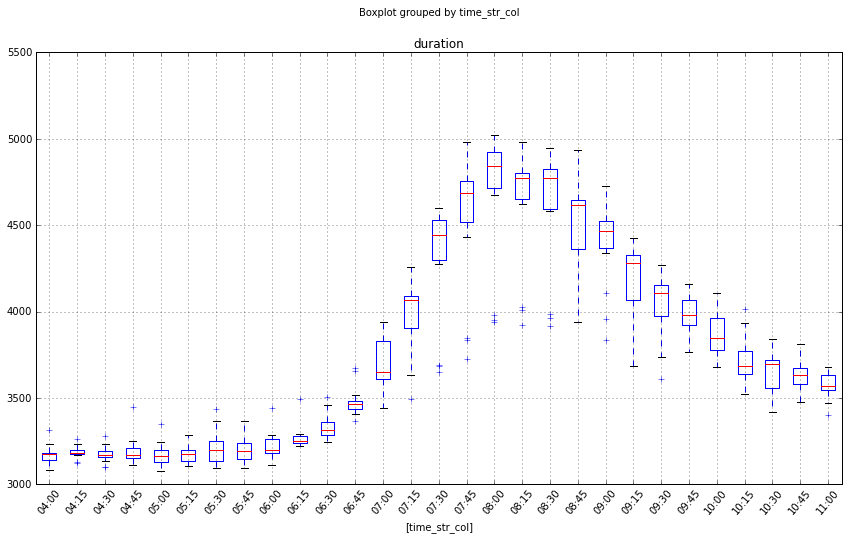

In [1983]:
current_df.ix[:,['duration','time_str_col']].boxplot(by='time_str_col',rot=50,figsize=(14,8))

In [1984]:
#add minutes and seconds cols to the current df
minutes = []
for each_time in current_df['time_col']:
    hour = each_time.hour
    minute = each_time.minute
    minute = minute + (60 * hour)
    minutes.append(minute)
seconds = []
for each_time in current_df['time_col']:
    this_hour = each_time.hour
    this_minute = each_time.minute
    this_seconds = (3600*this_hour) + (60*this_minute)
    seconds.append(this_seconds)

In [1985]:
current_df['minutes_col'] = minutes
current_df['seconds_col'] = seconds

In [1961]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix,\
                explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.cross_validation import train_test_split
from future import *
import matplotlib.pyplot as plt

In [1962]:
#1implement train/test/split - Wednesday, May 13 is the test day
#x_train = np.append((current_df['4/27/2015':'5/12/2015']['seconds_col'].values), (current_df['5/14/2015':'5/15/2015']['seconds_col'].values)).ravel()[:,np.newaxis]
#y_train = np.append((current_df['4/27/2015':'5/12/2015']['duration'].values), (current_df['5/14/2015':'5/15/2015']['duration'].values))
#x_test = current_df['5/13/2015':'5/13/2015']['seconds_col'].values[:,np.newaxis]
#y_test = current_df['5/13/2015':'5/13/2015']['duration'].values

In [1963]:
#1implement train/test/split - Friday, May 15 is the test day
#x_train = current_df['4/27/2015':'5/14/2015']['seconds_col'].values[:,np.newaxis]
#y_train = current_df['4/27/2015':'5/14/2015']['duration'].values
#x_test = current_df['5/15/2015':'5/15/2015']['seconds_col'].values[:,np.newaxis]
#y_test = current_df['5/15/2015':'5/15/2015']['duration'].values

In [1964]:
#using sklearn train_test_split
ev_scores = []
r2_scores = []
for this_random_state in np.arange(1000):
    x = current_df['4/27/2015':'5/15/2015']['seconds_col'].values[:,np.newaxis]
    y = current_df['4/27/2015':'5/15/2015']['duration'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=this_random_state)
    model = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression(fit_intercept=False))])
    model = model.fit(x_train,y_train)
    predicted = model.predict(x_test)
    predicted = predicted.astype(np.int64)
    y_test = y_test.astype(np.int64)
    ev_scores.append(explained_variance_score(y_test, predicted))
    r2_scores.append(r2_score(y_test, predicted))
ev_scores = np.array(ev_scores)
print ev_scores.mean()
r2_scores = np.array(r2_scores)
print r2_scores.mean()

0.665627531813
0.662016565777


In [1939]:
model = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression(fit_intercept=False))])
#model = LinearRegression()
model = model.fit(x_train,y_train)

In [1940]:
predicted = model.predict(x_test)
predicted = predicted.astype(np.int64)
y_test = y_test.astype(np.int64)
#print predicted; print y_test

In [1941]:
explained_variance_score(y_test, predicted) #1 - ((y_test - predicted).var()/(y_test.var()))

0.78610024159119318

In [795]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa

In [858]:
x = current_df[(current_df.index.hour >= 4) & (current_df.index.hour <=11)].index.values
y = current_df[(current_df.index.hour >= 4) & (current_df.index.hour <=11)]['duration'].values

In [867]:
results = tsa.ar_model.AR(current_df['duration'])

In [868]:
results.fit()

In [883]:
tsa.ar_model.ARResults(results,(y,x))

AttributeError: 'ARResults' object has no attribute 'summary'

In [926]:
arma_mod = sm.tsa.ARMA(current_df[(current_df.index.hour >= 4) & (current_df.index.hour <=11)]['duration'], order=(2,2))
arma_res = arma_mod.fit(trend='nc', disp=-1)
print tsa.arima_model.ARMA.score(arma_mod,current_df[(current_df.index.hour >= 4) & (current_df.index.hour <=11)]['duration'])

Exception: Data must be 1-dimensional

In [ ]:
#write to csv
#df.to_csv('foo.csv')
#read from csv
#pd.read_csv('foo.csv')
'''
normalizaiton
regularization
regression
auto regression
arma
statsmodels
time series
'''